# **Eksploracja danych**

## **Projek 2: Klasyfikacja przy użyciu KNN**  
## Krzysztof Stawarz

In [1]:
GlassData = cell2mat(struct2cell(load('ed-p02.mat', 'GlassData')));

In [2]:
GlassClasses = cell2mat(struct2cell(load('ed-p02.mat', 'GlassClasses')));

In [3]:
TestData = cell2mat(struct2cell(load('ed-p02.mat', 'TestData')));

### **Rozwiązanie typu: od zera**

*Piszemy wszystko od początku (pomimo, że ktoś mądry kiedyś za nas już to napisał, ale to nieistotne!!!)*

#### **Krok 1.**

*Dzielimy obecny dataset na zbiór do nauki ( `train_data` ) i przetestowania rezutlatów ( `test_data` ).  
Robimy to też z labelami - `train_labels` i `test_labels`.*  
  
*Ja preferuję podział 3:1 dla testowego, ale można sobie wybrać dowolny. Raczej nie przekracza się 50%/50%.*

In [4]:
train_frac = .75;

In [5]:
%  wektor decyzyjny z losowymi wartosciami, to dzieki niemu decydujemy czy wiersz dopisac do sekcji treningowej czy testowej
decision_vect = rand(size(GlassData, 1), 1);

train_data = GlassData(decision_vect <= train_frac, :);
train_labels = GlassClasses(decision_vect <= train_frac, :);

test_data = GlassData(decision_vect > train_frac, :);
test_labels = GlassClasses(decision_vect > train_frac, :);

#### **Krok 2.**

*Wprowadzamy kilka zmiennych służących nam za skróty, żeby nie pisać kilka razy tego samego*

In [6]:
train_rows_n = size(train_data, 1)
train_cols_n = size(train_data, 2)

test_rows_n = size(test_data, 1)


train_rows_n =

   115


train_cols_n =

     9


test_rows_n =

    48



#### **Krok 3.**

*Zaczynamy od rzeczy trywialnych. Napiszmy pętlę `for`, zliczającą odległość (w metryce taksówkowej) parametrów z pierwszego wiersza zbioru testowego i treningowego:*

$d(x, y) = \sum\limits_{i=0}^{n}|x_1 - y_1| + |x_2 - y_2| + ... + |x_i - y_i|$

In [7]:
distance = 0;
for i = 1:train_cols_n
    distance = distance + abs(train_data(1, i) - test_data(1, i));
end

distance


distance =

   26.3400



#### **Krok 4.**

*Potrafiąc policzyć dystans jednego wiersza testowego do jednego treningowego, możemy teraz policzyć dystanse jednego wiersza testowego do **każego** wiersza treningowego (zapisując wyniki z zmiennej `distances`:*

In [8]:
distances = [];

    for j=1:train_rows_n
    
        distance = 0;
        for i = 1:train_cols_n
            distance = distance + abs(train_data(j, i) - test_data(1, i));
        end
        
        distances = [distances, distance];

    end

% dystanse to wektor poziomy, stransponuje go i skrócę do pierwszych 5-ciu wyników w celu wyświetlenia
% aby nie zajmował niepotrzebnie miejsca (bedzie mial +/- 126 wierszy)
distances(:, 1:5)'


ans =

   26.3400
   54.2701
   21.9300
    9.2800
   17.2800



*Musimy się na tym etapie stety bądź nie trochę ubrudzić.*  
1. *Będziemy chcieli zmapować dystanse do odpowiednich wierszy jako pary {dystans: label_wiersza}. Użyjemy do tego celu słownika, a właściwie funkcji `sorted_dict`, napisanej w osobnym pliku w tym folderze. Funkcja ta zwraca słownik takich par, posortowany rosnąco według kluczy (dystansów), co będzie przydatne w dalszym etapie rozwiązania*  

In [9]:
d = sorted_dict(distances', train_labels)


d = 

  dictionary (double --> double) with 115 entries:

    0.6700  --> 2
    0.9600  --> 1
    1.0300  --> 1
    1.1600  --> 1
    1.1900  --> 2
    1.3700  --> 2
    1.4000  --> 1
    1.4200  --> 1
    1.4700  --> 2
    1.6500  --> 1
    1.7300  --> 1
    1.7900  --> 2
    1.8100  --> 1
    1.8300  --> 2
    1.8400  --> 1
    2.1800  --> 1
    2.3700  --> 2
    2.4300  --> 1
    2.4600  --> 1
    2.5600  --> 2
    2.6400  --> 3
    2.7600  --> 2
    2.8100  --> 1
    3.0000  --> 1
    3.1400  --> 1
    3.3000  --> 1
    3.5700  --> 1
    3.6300  --> 2
    3.6600  --> 2
    3.6800  --> 2
    3.8400  --> 1
    3.8800  --> 2
    4.0500  --> 1
    4.3400  --> 2
    4.3500  --> 1
    4.3500  --> 2
    4.3700  --> 2
    4.7000  --> 1
    4.7700  --> 1
    4.8500  --> 2
    4.9300  --> 2
    5.0100  --> 2
    5.2300  --> 2
    5.2600  --> 1
    5.2800  --> 3
    5.3000  --> 1
    5.4000  --> 1
    5.4300  --> 1
    5.8200  --> 2
    5.9000  --> 1
    5.9200  --> 5
    5.9800  --> 1
    6

*Posiadając taki słownik, możemy użyć już algorytmu __KNN__ - możemy sklasyfikować obserwację do jednej z sześciu klas.*

2. *Aplikujemy algorytm __KNN__, co oznacza, że będziemy patrzeć na __k__ najbliższych sąsiadów, czyli __k__ najmniejszych dystansów, oraz na labele wierszy, do których się odnoszą (stąd użycie słownika, chcemy śledzić obydwie wartości naraz i ich nie pogubić)*  
*Do wyznaczania współczynnika __k__ przejdziemy w ostatnim kroku, na razie przyjmijmy __k=10__ na potrzeby prezentacji pomysłu.*  
*Funkcja `sorted_dict` ma zaimplementowane użycie trzeciego argumentu jako współczynnika __k__ - uzystany w ten sposób słownik będzie posiadał __k__ pierwszych par.*

In [10]:
k = 10;

d = sorted_dict(distances', train_labels, k)


d = 

  dictionary (double --> double) with 10 entries:

    0.6700 --> 2
    0.9600 --> 1
    1.0300 --> 1
    1.1600 --> 1
    1.1900 --> 2
    1.3700 --> 2
    1.4000 --> 1
    1.4200 --> 1
    1.4700 --> 2
    1.6500 --> 1



3. *Gdy uzyskamy słownik z __k__ najmniejszymi dystansami, musimy znaleźć najczęściej występujący w nim label - to będzie nasza __predykacja, strzał, przewidywanie lub klasyfikacja__, jak zwał tak zwał*  
*Do znaleziena najczęściej występującej wartości (labelu) w słowniku służy funkcja `most_frequent_value`, napisana w osobnym pliku w tym folderze.*

In [11]:
predicted_label = most_frequent_value(d)


predicted_label =

     1



*Powyższa odpowiedź oznacza, że nasz zaimplementowany algorytm na podstawie danych jakie otrzymał (pamiętajmy __k__ = 10) uważa, że pierwszy wiersz w zbiorze testowym powinien należeć do klasy nr 1.*  
*Z racji, że zbiór testowy wyodrębniliśmy z naszego pierwotnego datasetu, możemy sprawdzić dokładność tej predykcji w niezwykle binarny sposób - przyrównać predykcję algorytmu do faktycznie przydzielonej do obserwacji klasy:*

In [12]:
predicted_label == test_labels(1, :)


ans =

  logical

   0



*Hurra! Udało nam się napisać algorytm KNN dla jednego wiersza!*  
  
#### __Krok 5.__  
  

*Teraz zamknijmy go w pętli, aby przeszedł po każdym wierszu ze zbioru do testu. W dodatku będziemy mogli w ten sposob policzyć jego dokładność, śledząc stosunek udanych predykcji do wszystkich obrotów pętli `for`:*

In [13]:
all_guesses = 0;
correct_guesses = 0;

for test_row=1:test_rows_n   
    all_guesses = all_guesses + 1;
    
    distances = [];

    for j=1:train_rows_n

        distance = 0;
        for i = 1:train_cols_n
            distance = distance + abs(train_data(j, i) - test_data(test_row, i));
        end

        distances = [distances, distance];

    end
    
     d = sorted_dict(distances', train_labels, k);
     predicted_label = most_frequent_value(d);

     if predicted_label == test_labels(test_row, :)
        correct_guesses = correct_guesses + 1;
     end
    
end

accuracy = correct_guesses / all_guesses


accuracy =

    0.5417



*Taka jest dokładność naszego algorytmu przy takim losowym podziale na testówke i treningówę i, co ważne, przy parametrze __k__=10*

#### __Krok 6.__

*Jak znajdziemy najbardziej optymalny współczynnik __k__? My użyjemy algorytmu nazywającego się __brute force__. Przeitereujemy po wszystkich możliwych wartościach __k__ i znajdziemy ten z największą dokładnością!*  
__UWAGA__ : zabezpieczymy się przed losowością kilku pierwszych wartości __k__ (dokładnie to pierwszych pięciou) przy użyciu `if`!!!

In [14]:
accuracy_arr = [];

for k = 1:train_rows_n   

    all_guesses = 0;
    correct_guesses = 0;

    for test_row = 1:test_rows_n   
        all_guesses = all_guesses + 1;

        distances = [];

        for j = 1:train_rows_n

            distance = 0;
            for i = 1:train_cols_n
                distance = distance + abs(train_data(j, i) - test_data(test_row, i));
            end

            distances = [distances, distance];

        end

         d = sorted_dict(distances', train_labels, k);
         predicted_label = most_frequent_value(d);

         if predicted_label == test_labels(test_row, :)
            correct_guesses = correct_guesses + 1;
         end

    end

    accuracy = correct_guesses / all_guesses;
    
    if k <= 5
        accuracy = 0;
    end
    
    accuracy_arr = [accuracy_arr, accuracy];
end

*Algorytm napisany, poniżej wizualizacja podsumowująca wszystkie współczynniki __k__ wraz z ich dokładnościami:*


k =

     8


k_acc =

    0.6042



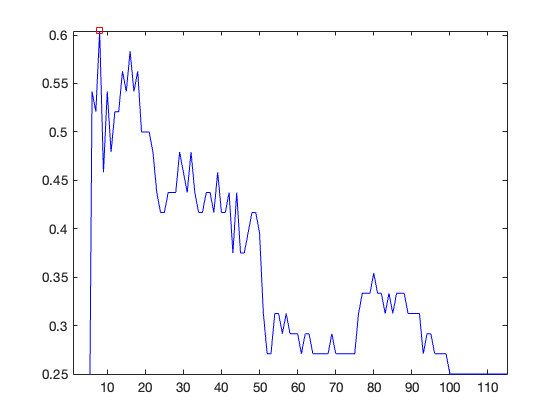

In [15]:
x = 1:train_rows_n;
y = accuracy_arr;

plot(x, y, 'b-');
xlim([1 train_rows_n]);
ylim([min(accuracy_arr(:, 6:end)) max(accuracy_arr)]);

hold on;

k = find(accuracy_arr == max(accuracy_arr), 1)
k_acc = max(accuracy_arr)

plot(k, k_acc, 'rsquare');

*W ten oto sposób napisaliśmy prosty algorytm __KNN__ od zera oraz przy okazji znaleźliśmy najbardziej optymalny współczynnik __k__ dla naszego datasetu.*  

#### __Krok 7.__

*Teraz należy tylko użyć algorytmu i spredykować klasy dla wierszy ze zmiennej `TestData`:*

In [16]:
predicts = [];

for test_row = 1:size(TestData, 1)  

        distances = [];

        for j = 1:size(GlassData, 1)

            distance = 0;
            for i = 1:train_cols_n
                distance = distance + abs(GlassData(j, i) - TestData(test_row, i));
            end

            distances = [distances, distance];

        end

         d = sorted_dict(distances', GlassClasses, k);
         predicted_label = most_frequent_value(d);
         
         predicts = [predicts predicted_label];
end


ans = dictionary(1:size(TestData, 1), predicts)


ans = 

  dictionary (double --> double) with 30 entries:

    1  --> 2
    2  --> 1
    3  --> 5
    4  --> 1
    5  --> 1
    6  --> 2
    7  --> 1
    8  --> 1
    9  --> 2
    10 --> 1
    11 --> 1
    12 --> 2
    13 --> 2
    14 --> 4
    15 --> 2
    16 --> 4
    17 --> 1
    18 --> 1
    19 --> 1
    20 --> 1
    21 --> 1
    22 --> 1
    23 --> 1
    24 --> 4
    25 --> 4
    26 --> 2
    27 --> 4
    28 --> 1
    29 --> 4
    30 --> 1



*Krzysztof Stawarz*  
*Kraków, 14.03.2023*